1. try frcnn pytorch and visualize

2. wrap frcnn outputs to oda format

3. apply tta

4. visualize results



In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import matplotlib.pyplot as plt
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
from utils.cococls import get_cls
import numpy as np

In [5]:
cococlass = get_cls()

In [6]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## load img

In [7]:
def loadimg(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img = cv2.imread(path)
    img = cv2.resize(img, (1024,1024))
    img = img.transpose([2,0,1]) / 255 # 0-1 float!
    return torch.from_numpy(img).unsqueeze(0).to(device).float()

(3, 469, 750)

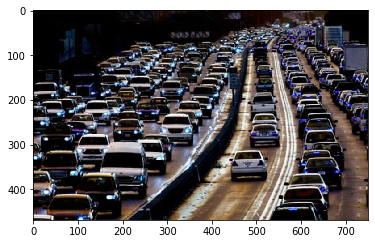

In [10]:
img = cv2.imread("imgs/cars.jpg")
plt.imshow(img)
img = img.transpose([2,0,1])
img.shape

In [11]:
model.eval().to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

## inference

In [12]:
def inference(img):
    with torch.no_grad():
        results = model(img)
    return results

In [ ]:
for impath in ["cars.jpg", "cars2.jpg", "cars3.jpg"]:
    img = loadimg(impath)
    results = inference(img)

    boxes = results[0]["boxes"].cpu().numpy()
    scores = results[0]["scores"].cpu().numpy()
    labels = results[0]["labels"].cpu().numpy()

    fig = plt.figure(figsize=(16,16))
    sample = cv2.imread(impath)
    for i, box in enumerate(boxes):
        cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  220, 2)
        cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class
    plt.imshow(sample[:,:,::-1])#BGR2RGB
    plt.show()

In [2]:
for impath in ["cars.jpg", "cars2.jpg", "cars3.jpg"]:
    img = loadimg(impath)
    results = inference(img)
    
    scores = results[0]["scores"].cpu().numpy()
    boxes = results[0]["boxes"].cpu().numpy()[scores<0.5]
    labels = results[0]["labels"].cpu().numpy()[scores<0.5]
    scores = scores[scores<0.5]

    fig = plt.figure(figsize=(16,16))
    sample = cv2.imread(impath)
    for i, box in enumerate(boxes):
        cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  220, 2)
        cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class
    plt.imshow(sample[:,:,::-1])#BGR2RGB
    plt.show()

NameError: name 'loadimg' is not defined

In [3]:
for impath in ["cars.jpg", "cars2.jpg", "cars3.jpg"]:
    img = loadimg(impath)
    results = inference(img)

    boxes = results[0]["boxes"].cpu().numpy()
    scores = results[0]["scores"].cpu().numpy()
    labels = results[0]["labels"].cpu().numpy()
    
    # scale box to 0-1
    if np.max(boxes)>1:
        boxes[:,0] /= img.shape[3]
        boxes[:,2] /= img.shape[3]
        boxes[:,1] /= img.shape[2]
        boxes[:,3] /= img.shape[2]
    iou_thr = 0.5
    skip_box_thr = 0.0001
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], 
                                                  weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        
    # Viz
    fig = plt.figure(figsize=(16,16))
    sample = cv2.imread(impath)
    img = cv2.imread(impath)
    # rescale boxes to image size
    boxes[:,0] *= img.shape[1]
    boxes[:,2] *= img.shape[1]
    boxes[:,1] *= img.shape[0]
    boxes[:,3] *= img.shape[0]
    for i, box in enumerate(boxes):
        cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  220, 2)
        cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class
    
    plt.imshow(sample[:,:,::-1])#BGR2RGB
    plt.show()

NameError: name 'loadimg' is not defined

# TTA

In [13]:
# based on https://github.com/andrewekhalel/edafa/tree/master/edafa
# and https://www.kaggle.com/shonenkov/wbf-over-tta-single-model-efficientdet

import torch.nn.functional as F

class Base():
    def __init__(self, imsize):
        self.imsize = imsize

    def augment(self, image):
        # pass torch tensors
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(Base):
    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.imsize - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(Base):
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.imsize - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(Base):
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.imsize - boxes[:, [3,1]] 
        res_boxes[:, [1,3]] = boxes[:, [0,2]]
        return res_boxes

class TTAScale(Base):
    # change brightness of image
    def __init__(self, scale):
        # scale is a float value 0.5~1.5
        self.scale = scale
    def augment(self, image):
        return image*self.scale    
    def batch_augment(self, images):
        return images*self.scale    
    def deaugment_boxes(self, boxes):
        return boxes

class TTAMultiScale(Base):
    # change brightness of image
    def __init__(self, original, imscale):
        # scale is a float value 0.5~1.5
        self.imscale = imscale
        self.original = original
    def augment(self, image):
        return F.interpolate(image, scale_factor=self.imscale)  
    def batch_augment(self, images):
        return F.interpolate(images, scale_factor=self.imscale)
    def deaugment_boxes(self, boxes):
        return boxes/self.imscale

class TTAMultiScaleFlip(Base):
    # change brightness of image
    def __init__(self, original, imscale):
        # scale is a float value 0.5~1.5
        self.imscale = imscale
        self.original = original
    def augment(self, image):
        return F.interpolate(image, scale_factor=self.imscale).flip(2)
    def batch_augment(self, images):
        return F.interpolate(images, scale_factor=self.imscale).flip(3)
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.original*self.imscale - boxes[:, [2,0]]
        boxes = boxes/self.imscale
        return boxes
    
class TTACompose(Base):
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [52]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAVerticalFlip(1024), None],
                               [TTAScale(0.9), None],
                               [TTAScale(1.1), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))
    
for tta_combination in [TTAMultiScale(1024,0.9), TTAMultiScale(1024,1.1), TTAMultiScale(1024,0.8), TTAMultiScale(1024,1.2),
                        TTAMultiScaleFlip(1024,0.9), TTAMultiScaleFlip(1024,1.1),
                       TTAMultiScaleFlip(1024,0.8), TTAMultiScaleFlip(1024,1.2)] :
    tta_transforms.append(TTACompose([tta_combination]))

no TTA


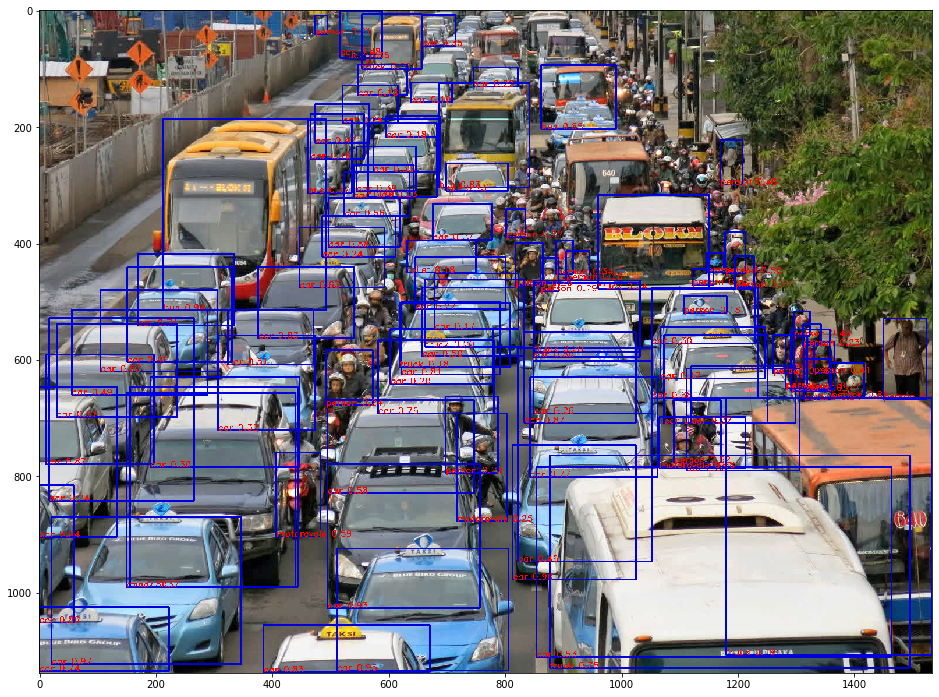

w/TTA


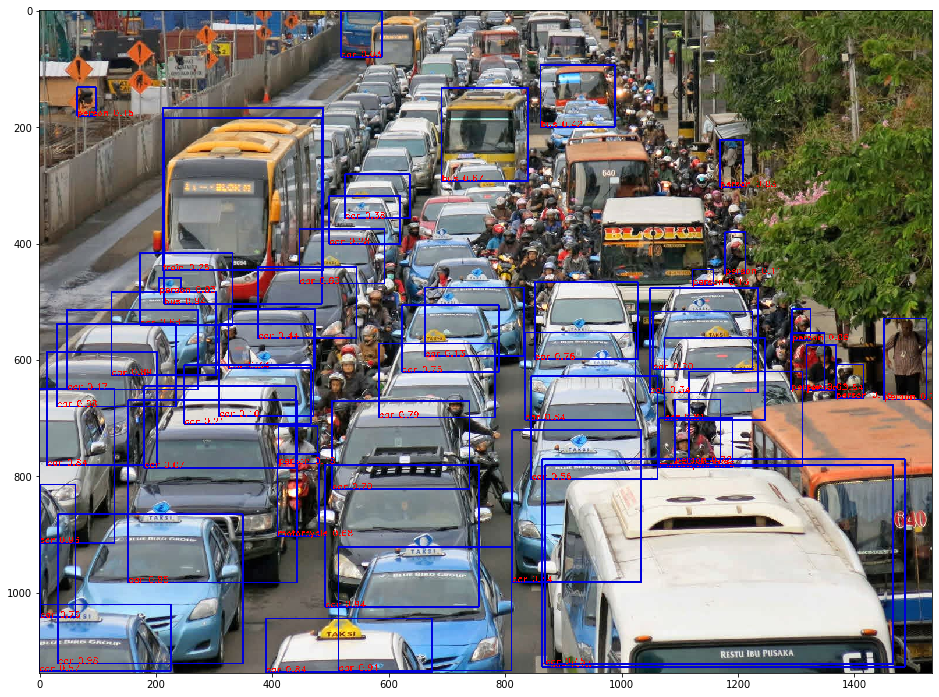

In [55]:
impath = "cars2.jpg"

print("no TTA")
img = loadimg(impath)
results = inference(img)

boxes = results[0]["boxes"].cpu().numpy()
scores = results[0]["scores"].cpu().numpy()
labels = results[0]["labels"].cpu().numpy()

# scale box to 0-1
if np.max(boxes)>1:
    boxes[:,0] /= img.shape[3]
    boxes[:,2] /= img.shape[3]
    boxes[:,1] /= img.shape[2]
    boxes[:,3] /= img.shape[2]
iou_thr = 0.5
skip_box_thr = 0.0001
boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], 
                                              weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

# Viz
fig = plt.figure(figsize=(16,16))
sample = cv2.imread(impath)
img = cv2.imread(impath)
# rescale boxes to image size
boxes[:,0] *= img.shape[1]
boxes[:,2] *= img.shape[1]
boxes[:,1] *= img.shape[0]
boxes[:,3] *= img.shape[0]
for i, box in enumerate(boxes):
    cv2.rectangle(sample,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              220, 2)
    cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class

plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()

print("w/TTA")
img = loadimg(impath)
thresh = 0.4

boxes = []; scores = []; labels = [];
for tta in tta_transforms:
    # gen img
    inf_img = tta.batch_augment(img.clone())
    results = inference(inf_img)
    box = results[0]["boxes"].cpu().numpy()
    box = tta.deaugment_boxes(box)
    # scale box to 0-1
    if np.max(box)>1:
        box[:,0] /= img.shape[3]
        box[:,2] /= img.shape[3]
        box[:,1] /= img.shape[2]
        box[:,3] /= img.shape[2]
    
    ind = results[0]["scores"].cpu().numpy() > thresh
    boxes.append(box[ind])
    scores.append(results[0]["scores"].cpu().numpy()[ind])
    labels.append(results[0]["labels"].cpu().numpy()[ind])

iou_thr = 0.5
skip_box_thr = 0.5
boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, 
                                              weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

# Viz
fig = plt.figure(figsize=(16,16))
sample = cv2.imread(impath)
# rescale boxes to image size
boxes[:,0] *= sample.shape[1]
boxes[:,2] *= sample.shape[1]
boxes[:,1] *= sample.shape[0]
boxes[:,3] *= sample.shape[0]
for i, box in enumerate(boxes):
    cv2.rectangle(sample,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              220, 2)
    cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class

plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()

In [15]:
labels

array([3., 3., 3., 3., 4., 3., 8., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 8., 3., 3., 3., 1.,
       3., 3., 3., 8., 3., 3., 8., 3., 3., 3., 8., 3., 3., 3., 3., 8., 3.,
       3., 3., 8., 3., 3., 8., 3., 3., 8., 1., 3., 3., 3., 3., 8., 3., 8.,
       6., 3., 8.])

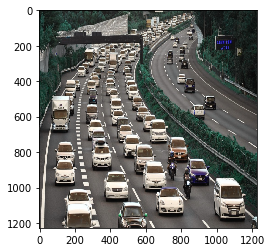

In [36]:
tta = TTAMultiScaleFlip(1024, 1.2)
img = loadimg(impath)
plt.imshow(tta.batch_augment(img).cpu().numpy()[0].transpose([1,2,0]))

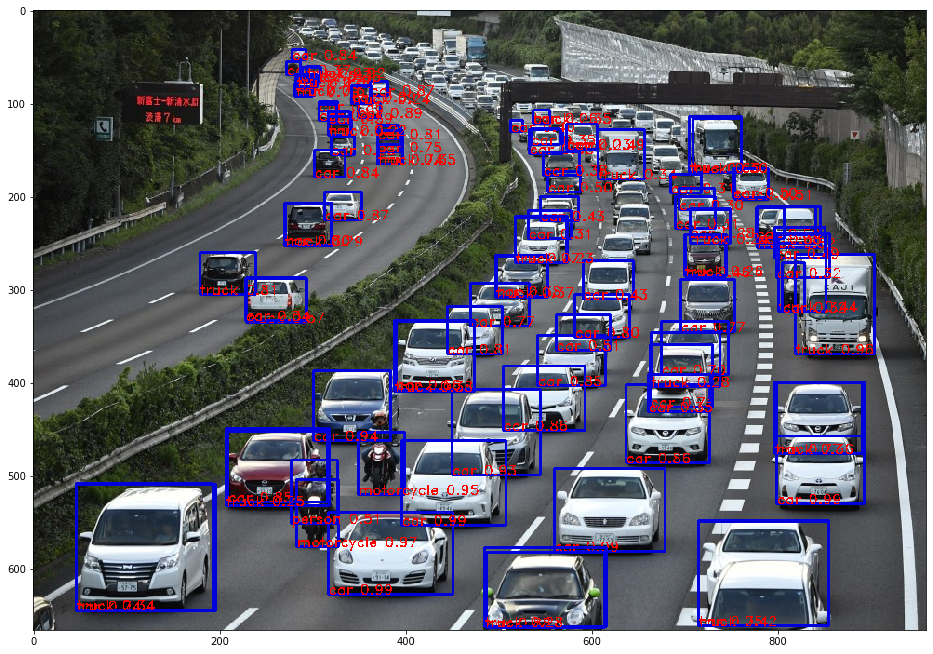

In [37]:
tta = TTAMultiScaleFlip(1024, 1.1)
img = loadimg(impath)
results = inference(tta.batch_augment(img))
boxes = tta.deaugment_boxes(results[0]["boxes"].cpu().numpy())
scores = results[0]["scores"].cpu().numpy()
labels = results[0]["labels"].cpu().numpy()

# scale box to 0-1
if np.max(boxes)>1:
    boxes[:,0] /= img.shape[3]
    boxes[:,2] /= img.shape[3]
    boxes[:,1] /= img.shape[2]
    boxes[:,3] /= img.shape[2]

# Viz
fig = plt.figure(figsize=(16,16))
sample = cv2.imread(impath)
# rescale boxes to image size
boxes[:,0] *= sample.shape[1]
boxes[:,2] *= sample.shape[1]
boxes[:,1] *= sample.shape[0]
boxes[:,3] *= sample.shape[0]
for i, box in enumerate(boxes):
    cv2.rectangle(sample,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              220, 2)
    cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class

plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()